<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SET UP ENVIRONMENT 

# mount google drive for data storage and access
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# IMPORTS

import os
import copy
import math

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes(palette='colorblind')

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
# STORE DIRECTORY WHERE DATA IS STORED

# this is an absolute path 
# and be sure to include trailing '/'
data_dir = '/content/drive/MyDrive/Adam Gibbs/data/'
model_dir = data_dir + 'models/'
fig_dir = data_dir + 'figs/'
testing_dir = data_dir + 'testing/'

# model hyperparams
layer1=64
layer2=32
dyear = True
w_pres = False
tanh = True
sigm = False

# inputs not to include for this model
# i.e. exclude (1,2) if model doesn't take location data
to_remove = ()

shallow = 200
d_label = "\n(Depths <{})".format(shallow)

m_col = 'b'
c_col = 'g'

# save figures?
save_figs = False
# display figures?
show_figs = True

In [ ]:
if dyear:
  model_modifier = "dyear"
else:
  model_modifier = "sin"

if w_pres:
  model_modifier += "_pres"

act_modifier = ""
if tanh:
  act_modifier = "tanh_"
elif sigm:
  act_modifier = "sigm"

final_model_name = 'Our Model'
model_name = act_modifier + "DNN({},{})".format(layer1, layer2) + model_modifier
model_name = "dropout_tanh_DNN(64,64)dyear"
model_path = model_dir + model_name

# Data QC, Cleaning, and preprocessing Functions

In [ ]:
# FUNCTION TO READ GLIDER FILE IN A PANDAS DATAFRAME
def read_glider_file(file):
  names = [ 'Cruise', 'Station', 'Type',	'DATE', 'TIME', 'LONGITUDE',	
         'LATITUDE',	'QF',	'PRS', 'PRS_QF', 'TMP', 'TMP_QF', 
         'SAL', 'SAL_QF', 'Sigma_theta', 'ST_QF', 'DEPTH', 'DEPTH_QF', 
         'OXYGEN', 'OXYGEN_QF',	'SATOXY',	'SATOXY_QF',	'NITRATE', 
         'NITRATE_QF', 'CHL_A', 'CHL_A_QF', 'BBP700', 'BBP700_QF', 'PH_INSITU', 
         'PH_INSITU_QF', 'BBP532', 'BBP_532_QF', 'CDOM', 'CDOM_QF', 'TALK_CANYONB',	
         'TALK_QF', 'DIC_CANYONB', 'DIC_QF', 'pCO2_CANYONB', 'pCO2_QF', 
         'SAT_AR_CANYONB', 'SAT_AR_QF', 'pH25C_1atm', 'pH25C_1atm_QF' ]

  df = pd.read_csv(file, skiprows=7, header=None, sep='\t', names=names)
  df = df.dropna(axis=0, how='any').reset_index(drop=True)
  
  return df

In [ ]:
def check_qfs(file, save_csv=True):
  # read in csv
  dataframe = read_glider_file(file)

  df = dataframe[[ 'PH_INSITU', 'PH_INSITU_QF', 'PRS', 'PRS_QF', 'TMP', 'TMP_QF', 
           'SAL', 'SAL_QF', 'OXYGEN', 'OXYGEN_QF']].to_numpy()

  for ind in range(0, len(df)):
    # check pH QFs
    pH = df[ind][0]
    qf = df[ind][1]
    if pH < 7.3 or pH > 8.5:
      df[ind][1] = 8
    elif ind > 1 and ind + 2 < len(df):
      test = pH - np.median((df[ind-2][0], df[ind-1][0], 
                              pH, 
                              df[ind+1][0], df[ind+2][0]))
      if abs(test) > 0.04:
        df[ind][1] = 8
        
    sal = df[ind][6]
    if sal < 33 or sal > 34.5:
      df[ind][7] = 8

    # check inputs QFs
    if float(df[ind][2]) == -999:
      df[ind][3] = 8
    if float(df[ind][4]) == -999:
      df[ind][5] = 8
    if float(df[ind][6]) == -999:
      df[ind][7] = 8
    if float(df[ind][8]) == -999:
      df[ind][9] = 8

  # update pH QFs
  dataframe['PH_INSITU_QF'] = df[:,1]
  # update inputs QFs
  dataframe['PRS_QF'] = df[:,3]
  dataframe['TMP_QF'] = df[:,5]
  dataframe['SAL_QF'] = df[:,7]
  dataframe['OXYGEN_QF'] = df[:,9]

  if save_csv:
    dataframe.to_csv(glider_dir + file[-12:-3] + 'csv', header=True, index=False)

  return dataframe

In [ ]:
# CREATE FUNCTION TO CREATE A NUMPY ARRAY OF INPUTS FROM
# GLIDER DATA FILE

'''
process_glider_input()
  description:
    This function reads in a data file in csv format and
    creates a pandas dataframe from it. From there it loops through
    and removes all bad data points according to the quality control
    flags. It then takes the desired input parameters as sepcified on 
    line 84 and puts them into a numpy array.

  args:
    file: string that contains file name of dataset
'''
def process_glider_file(df, save_txt=False, save_csv=False):

  # throw away first day
  start_date = int(df['DATE'][0][3:5])
  start_time = float(df['TIME'][0][0:2]) + float(df['TIME'][0][3:5]) / 60

  drop_index = 0
  for index, row in df.iterrows():
    curr_date = int(row['DATE'][3:5])
    curr_time = float(row['TIME'][0:2]) + float(row['TIME'][3:5]) / 60
    if (curr_date > start_date and curr_time > start_time) or curr_date > start_date + 1:
      drop_index = index
      break

  # drop first day of data
  df = df.drop(index=df.index[:drop_index], axis=0).reset_index(drop=True)

  # take only data we care about
  df = df[['DATE', 'LATITUDE', 'LONGITUDE', 'PRS', 'PRS_QF', 'TMP', 'TMP_QF',
          'SAL', 'SAL_QF', 'OXYGEN', 'OXYGEN_QF', 'SATOXY', 'SATOXY_QF',
          'PH_INSITU', 'PH_INSITU_QF', 'TALK_CANYONB', 'TALK_QF', 'DIC_CANYONB',
          'DIC_QF', 'pCO2_CANYONB', 'pCO2_QF']]

  # drop bad pressure
  index = 0
  to_drop = []
  for flag in df['PRS_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad temperature
  index = 0
  to_drop = []
  for flag in df['TMP_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad salinity
  index = 0
  to_drop = []
  for flag in df['SAL_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad oxygen
  index = 0
  to_drop = []
  for flag in df['OXYGEN_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad saturated oxygen
  index = 0
  to_drop = []
  for flag in df['SATOXY_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad pH
  index = 0
  to_drop = []
  for flag in df['PH_INSITU_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # take subset of only parameters for inputs
  # this array contains only "good" data points
  inputs = df[['DATE', 'LATITUDE', 'LONGITUDE', 'PRS', 'TMP', 'SAL', 'OXYGEN']]
  outputs = df['PH_INSITU']
  # convert dataframe in numpy array
  inputs = inputs.to_numpy(dtype='str')
  outputs = outputs.to_numpy(dtype='str')

  # change date format
  for row in inputs:
    date = row[0]
    row[0] = date[6:10] + date[0:2] + date[3:5]

  # return the array
  return inputs, outputs

In [ ]:
def prep_data(inputs, outputs, dyear=False):

  canyonb_inputs = copy.deepcopy(inputs)
  canyonb_outputs = copy.deepcopy(outputs)

  # TRANSFORM DATE AND PRESSURE INPUTS

  # method to help transform date
  def date_to_nth_day(the_date):
    date = pd.to_datetime(the_date)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    day_of_the_year = (date - new_year_day).days + 1
    return day_of_the_year

  # loop through inputs and perform transformations
  for input in inputs:
    # adjust date
    date = input[0]
    frac_year = date_to_nth_day(date) / 365.0
    if dyear:
      input[0] = int(date[0:4]) + frac_year 
    else:
      input[0] = math.sin(2*math.pi*frac_year)
    # adjust pressure
    if w_pres:
      pres = float(input[3])
      input[3] = ( pres/20000 ) + ( 1 / ( 1 + math.exp(-1*pres / 300) )**3 ) 

  # loop through inputs and perform transformations
  for input in canyonb_inputs:
    # adjust date
    date = input[0]
    date = date[0:4]+'-'+date[4:6]+'-'+date[6:8]
    input[0] = date
      
  return inputs, outputs, canyonb_inputs, canyonb_outputs

In [ ]:

input_arrays = []
output_arrays = []
canyonb_input_arrays = []
canyonb_output_arrays = []
for file in os.listdir(testing_dir):
  display(testing_dir+file)
  df = check_qfs(testing_dir+file, save_csv=False)

  curr_inputs, curr_outputs = process_glider_file(df)
  curr_inputs, curr_outputs, curr_canyonb_inputs, curr_canyonb_outputs = prep_data(curr_inputs, curr_outputs, dyear=dyear)
  input_arrays.append(curr_inputs)
  output_arrays.append(curr_outputs)
  canyonb_input_arrays.append(curr_canyonb_inputs)
  canyonb_output_arrays.append(curr_canyonb_outputs)

inputs = np.concatenate(input_arrays)
outputs = np.concatenate(output_arrays)
canyonb_inputs = np.concatenate(canyonb_input_arrays)
canyonb_outputs = np.concatenate(canyonb_output_arrays)

input_header = 'DATE, LATITUDE, LONGITUDE, CTDPRS, CTDTMP, CTDSAL, OXYGEN'
output_header = 'TOT_PH'
np.savetxt(data_dir + 'canyonb_inputs.csv', canyonb_inputs, 
            fmt='%s', delimiter=",", header=input_header)
np.savetxt(data_dir + 'canyonb_outputs.csv', canyonb_outputs, 
            fmt='%s', delimiter=",", header=output_header)

inputs = inputs.astype('float')
outputs = outputs.astype('float')

display(inputs.shape)
display(outputs.shape)

'/content/drive/MyDrive/Adam Gibbs/data/testing/19402901.txt'

'/content/drive/MyDrive/Adam Gibbs/data/testing/19502901.txt'

'/content/drive/MyDrive/Adam Gibbs/data/testing/20A03401.txt'

(233692, 7)

(233692,)

In [ ]:
# Take subset of inputs necessary for loaded model
test_inputs = np.delete(inputs, to_remove, axis=1)
display(test_inputs.shape)

(233692, 7)

# Load Model, Initially Evaluate, and Get Predictions



In [ ]:
# LOAD IN MODEL

model = tf.keras.models.load_model(model_dir+model_name, compile=True)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                512       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

Evaluating model on different datasets...
7303/7303 [==============================] - 13s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0061 - root_mean_squared_error: 0.0782



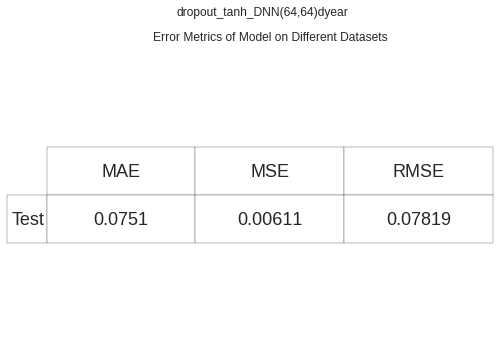

In [ ]:
# TEST INITIAL PERFORMANCE ON TRAINING, VALIDATION, & TESTING SETS
print('Evaluating model on different datasets...')
test_performance = model.evaluate(test_inputs, outputs) 
print()

# compile performance metrics
evaluations = np.round(np.array([test_performance[1:4]]),
                        decimals=5)

# create table
# labels for columns and rows
col_labels = np.array(('MAE', 'MSE', 'RMSE'))
row_labels = np.array(['Test'])
# add data to table
fig, ax = plt.subplots()
table = plt.table(cellText=evaluations, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
plt.title('Error Metrics of Model on Different Datasets')
plt.suptitle(model_name)
# scale plot
table.set_fontsize(18)
table.scale(1,4)
ax.axis('off')

# show plot
plt.show()

In [ ]:
# make predictions on testing dataset with neural network
test_predictions = model.predict(test_inputs, verbose=1).flatten()

In [ ]:
canyonb_outputs = np.loadtxt(data_dir+'canyonb_estimates.csv', 
                        delimiter=",", 
                        dtype='float')
index = 0
for pH in canyonb_outputs:
  canyonb_outputs[index] = pH - 0.3168 + 0.0404*pH
  index += 1

print(len(canyonb_outputs))
print(len(test_predictions))

# Get Depth Data

In [ ]:
# FUNCTION: CONVERT PRESSURE TO DEPTH
# Python version of the following MATLAB function
'''
% SW_DPTH    Depth from pressure
%===========================================================================
% SW_DPTH   $Id: sw_dpth.m,v 1.1 2003/12/12 04:23:22 pen078 Exp $
%           Copyright (C) CSIRO, Phil Morgan 1992.
%
% USAGE:  dpth = sw_dpth(P,LAT)
%
% DESCRIPTION:
%    Calculates depth in metres from pressure in dbars.
%
% INPUT:  (all must have same dimensions)
%   P   = Pressure    [db]
%   LAT = Latitude in decimal degress north [-90..+90]
%         (lat may have dimensions 1x1 or 1xn where P(mxn).
%
% OUTPUT:
%  dpth = depth [metres]
%
% AUTHOR:  Phil Morgan 92-04-06  (morgan@ml.csiro.au)
%
% DISCLAIMER:
%   This software is provided "as is" without warranty of any kind.
%   See the file sw_copy.m for conditions of use and licence.
%
% REFERENCES:
%    Unesco 1983. Algorithms for computation of fundamental properties of
%    seawater, 1983. _Unesco Tech. Pap. in Mar. Sci._, No. 44, 53 pp.
%=========================================================================
'''
def pres_to_depth(pres, lat):

  # define constants
  DEG2RAD = math.pi/180
  c1 = 9.72659
  c2 = -2.2512E-5
  c3 = 2.279E-10
  c4 = -1.82E-15
  gam_dash = 2.184E-6

  # convert latitude
  LAT = abs(lat)
  X = math.sin(LAT*DEG2RAD)
  X = X*X

  # calculate denomenator and numerator
  denom = 9.780318*(1.0+(5.2788E-3 + 2.36E-5*X)*X) + gam_dash*0.5*pres 
  numer = (((c4 * pres + c3) * pres + c2) * pres + c1) * pres

  # return quotient
  return numer / denom


# FUNCTION: CONVERT ARRAY OF INPUTS TO AN ARRAY OF DEPTHS
def get_depths(input_arr):
  # create numpy array to store depths
  depths = np.zeros(len(input_arr))
  # loop through inputs and calculate depth
  ind = 0
  for input in input_arr:
    depths[ind] = pres_to_depth(input[3], input[1])
    ind += 1
  # return depth array
  return depths


# get depths from inputs
test_depths = get_depths(inputs)

In [ ]:
# GET DATAPOINTS FROM SHALLOW DEPTHS (<200m)

# loop through depths and get indices of deep datapoints 
ind = 0
inds = []
for depth in test_depths:
  if depth > shallow:
    inds.append(ind)
  ind += 1

# delete deep datapoints and store resulting array of shallow datapoints
shallow_test_depths = np.delete(test_depths, inds, axis=0)
shallow_test_predictions = np.delete(test_predictions, inds, axis =0)
shallow_canyonb_outputs = np.delete(canyonb_outputs, inds, axis=0)
shallow_outputs = np.delete(outputs, inds, axis=0)

# ensure there are no deep datapoints
count = 0
for depth in shallow_test_depths:
  if depth > shallow:
    count += 1
print('Number of datapoints of depth greater than {}m: {}'.format(shallow, count))

print('Shape of each shallow data array (all should be equal):')
display(shallow_test_depths.shape)
display(shallow_test_predictions.shape)
display(shallow_canyonb_outputs.shape)
display(shallow_outputs.shape)

Number of datapoints of depth greater than 200m: 0
Shape of each shallow data array (all should be equal):


(114139,)

(114139,)

(114139,)

(114139,)

# Estimates vs Observations 1-1 Plots

In [ ]:
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.linewidth"]  = 0

## Overall Dataset

[]

Number of estimations not in range [7.3,8.5]: 0



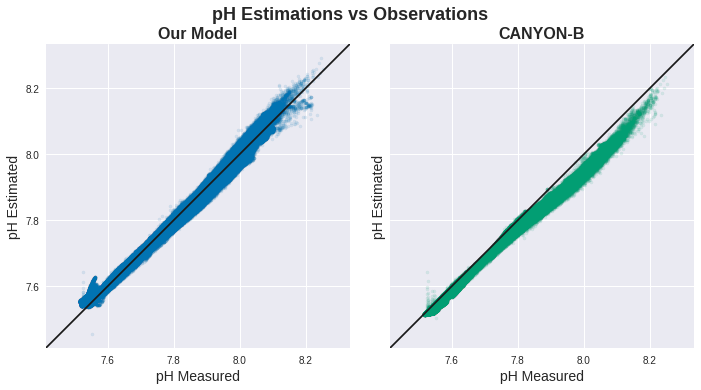

In [ ]:
# count how many estimations are outside range test
count = 0
ind = 0
inds = []
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
    inds.append(ind)
  ind += 1
display(inds)
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(outputs, test_predictions, label=final_model_name,
            color=m_col, s=10, alpha=0.1)
ax2.scatter(outputs, canyonb_outputs, label='CANYON-B',
            color=c_col, s=10, alpha=0.1)


ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

ax2.set_xlabel('pH Measured')
ax2.xaxis.label.set_size(14)
ax2.set_ylabel('pH Estimated')
ax2.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='k')
ax2.plot(lims,lims, color='k')

ax1.set_ylim(lims)
ax1.set_xlim(lims)

ax2.set_ylim(lims)
ax2.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations\n', y=1,
             va='center', fontsize=18, weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')
ax2.set_title('CANYON-B', fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.tight_layout()
  plt.savefig(fig_dir+'est_v_obs.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Shallow Test Dataset

Number of estimations not in range [7.3,8.5]: 0



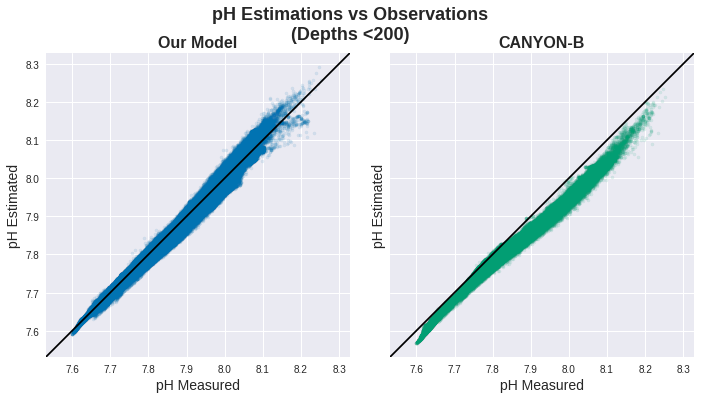

In [ ]:
# count how many estimations are outside range test
count = 0
ind = 0
for o in shallow_test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
  ind += 1
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(shallow_outputs, shallow_test_predictions, label=final_model_name,
            color=m_col, s=10, alpha=0.1)
ax2.scatter(shallow_outputs, shallow_canyonb_outputs, label='CANYON-B',
            color=c_col, s=10, alpha=0.1)


ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

ax2.set_xlabel('pH Measured')
ax2.xaxis.label.set_size(14)
ax2.set_ylabel('pH Estimated')
ax2.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='black')
ax2.plot(lims,lims, color='black')

ax1.set_ylim(lims)
ax1.set_xlim(lims)

ax2.set_ylim(lims)
ax2.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations' + d_label, y=1.025,
             va='center', fontsize=18, weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')
ax2.set_title('CANYON-B', fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'est_v_obs_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


# Depth vs Error Plots

## DNN Error Only

### Overall Test Dataset

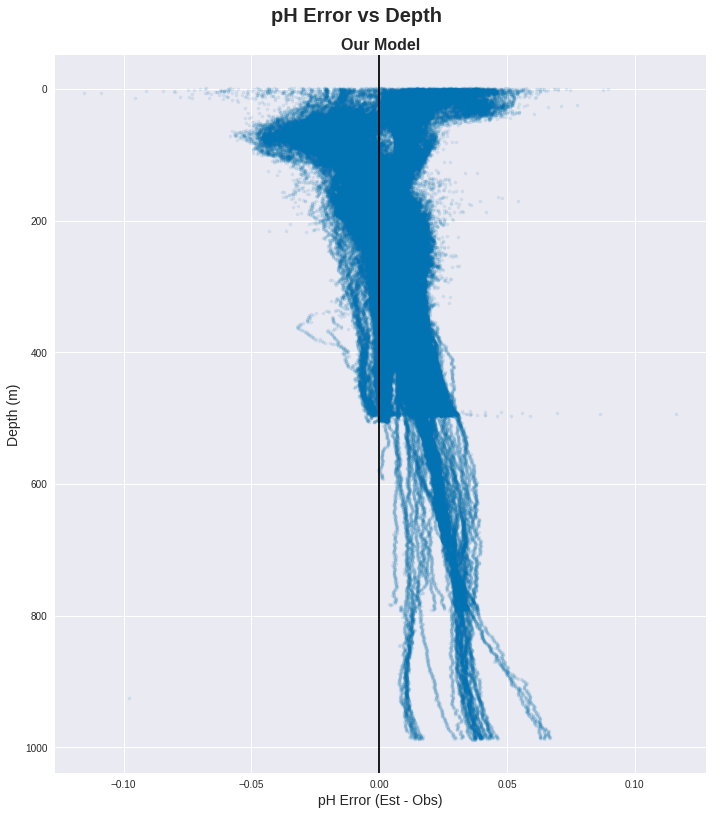

In [ ]:
# get errors (estimations - observations)
error = test_predictions - outputs

fig, ax = plt.subplots(1, figsize=(10,11))

# plot the scatter plots
ax.scatter(error, test_depths, label=final_model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth', y=1.025,
             fontsize=20, weight='bold')
ax.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth.png', bbox_inches='tight')
if show_figs:
  plt.show()


### Shallow Test Dataset

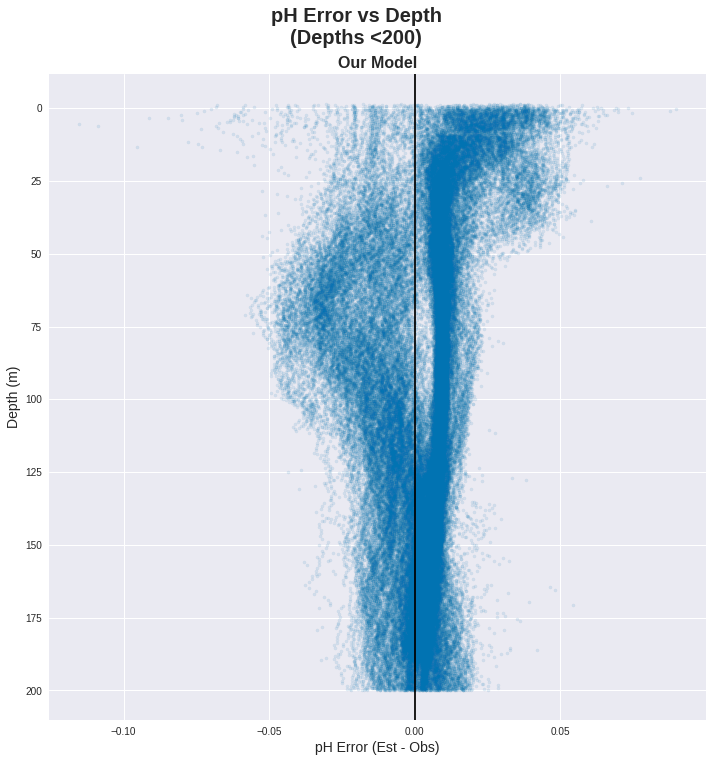

In [ ]:

# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_outputs

fig, ax = plt.subplots(figsize=(10,10))

# plot the scatter plots
ax.scatter(shallow_error, shallow_test_depths, label=final_model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth' + d_label, y=1.025,
             va='center', fontsize=20, weight='bold')
ax.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


## DNN & CANYON-B

### Overall Test Dataset

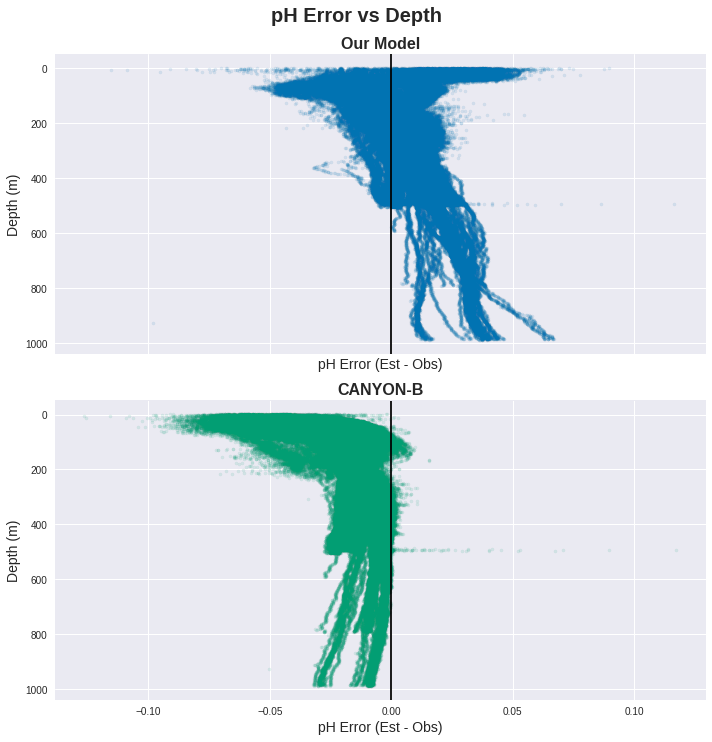

In [ ]:
# convert inputs to depths
test_depths = get_depths(test_inputs)

# get errors (estimations - observations)
error = test_predictions - outputs
error2 = canyonb_outputs - outputs

fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10), sharex=True)

# plot the scatter plots
ax1.scatter(error, test_depths, label=final_model_name,
            color=m_col, s=10, alpha=0.1)
ax2.scatter(error2, test_depths, label='CANYON-B',
            color=c_col, s=10, alpha=0.1)


# place a vertical line at x=0 to represent error=0
ax1.axvline(x=0, color='black')
ax2.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax1.invert_yaxis()
ax1.set_xlabel('pH Error (Est - Obs)')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('Depth (m)')
ax1.yaxis.label.set_size(14)

ax2.invert_yaxis()
ax2.set_xlabel('pH Error (Est - Obs)')
ax2.xaxis.label.set_size(14)
ax2.set_ylabel('Depth (m)')
ax2.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth', y=1,
             va='bottom', fontsize=20, weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')
ax2.set_title('CANYON-B', fontsize=16, weight='bold')

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth_w_canyonb.png', bbox_inches='tight')
if show_figs:
  plt.show()


### Shallow Test Dataset

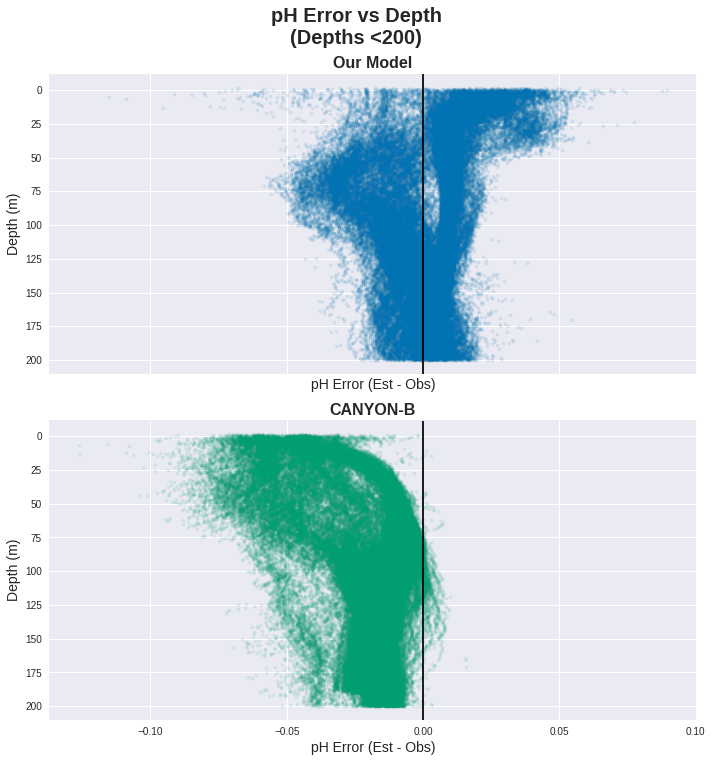

In [ ]:

# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_outputs
shallow_error2 = shallow_canyonb_outputs - shallow_outputs

fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10), sharex=True)

# plot the scatter plots
ax1.scatter(shallow_error, shallow_test_depths, label=final_model_name,
            color=m_col, s=10, alpha=0.1)
ax2.scatter(shallow_error2, shallow_test_depths, label='CANYON-B',
            color=c_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax1.axvline(x=0, color='black')
ax2.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax1.invert_yaxis()
ax1.set_xlabel('pH Error (Est - Obs)')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('Depth (m)')
ax1.yaxis.label.set_size(14)

ax2.invert_yaxis()
ax2.set_xlabel('pH Error (Est - Obs)')
ax2.xaxis.label.set_size(14)
ax2.set_ylabel('Depth (m)')
ax2.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth' + d_label, y=1.025,
             fontsize=20, va='center', weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')
ax2.set_title('CANYON-B', fontsize=16, weight='bold')

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth_w_canyonb_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Heatmaps

In [ ]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 2

### Overall Test Dataset

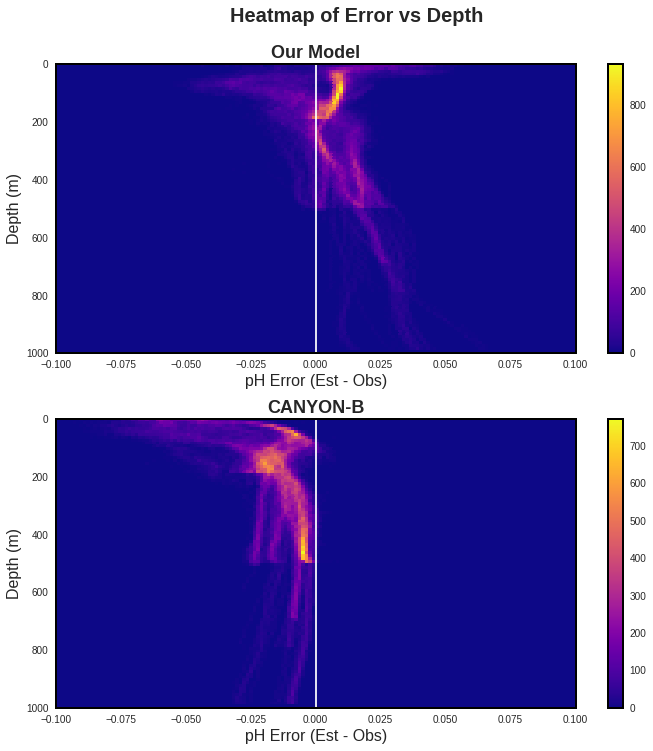

In [ ]:


fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0, 1000]]

hh1 = ax1.hist2d(error, test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

hh2 = ax2.hist2d(error2, test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax2.invert_yaxis()
ax2.axvline(x=0, color='w')
fig.colorbar(hh2[3], ax=ax2)

fig.suptitle('Heatmap of Error vs Depth', y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(final_model_name, fontsize=18, weight='bold')
ax2.set_title('CANYON-B', fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.xaxis.label.set_size(16)
ax1.set_ylabel('Depth (m)')
ax1.yaxis.label.set_size(16)

ax2.set_xlabel('pH Error (Est - Obs)')
ax2.xaxis.label.set_size(16)
ax2.set_ylabel('Depth (m)')
ax2.yaxis.label.set_size(16)

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir + 'err_v_depth_heatmap.png', bbox_inches='tight')
if show_figs:
  plt.show()

### Shallow Test Dataset

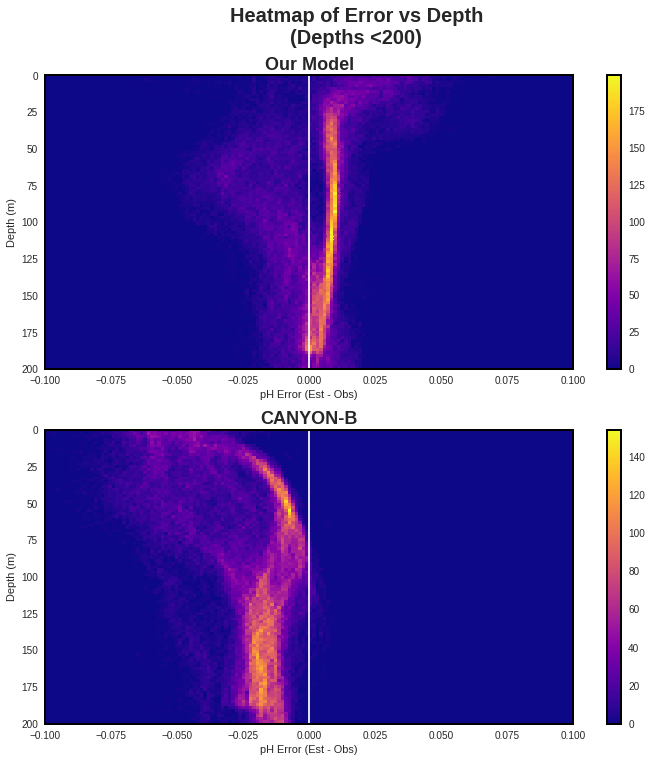

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0,shallow]]

hh1 = ax1.hist2d(shallow_error, shallow_test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

hh2 = ax2.hist2d(shallow_error2, shallow_test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax2.invert_yaxis()
ax2.axvline(x=0, color='w')
fig.colorbar(hh2[3], ax=ax2)

fig.suptitle('Heatmap of Error vs Depth' + d_label, y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(final_model_name, fontsize=18, weight='bold')
ax2.set_title('CANYON-B', fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.set_ylabel('Depth (m)')

ax2.set_xlabel('pH Error (Est - Obs)')
ax2.set_ylabel('Depth (m)')

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir+'err_v_depth_heatmap_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()

# Error Metrics
### MAE, MSE, RMSE

## Overall Test Dataset

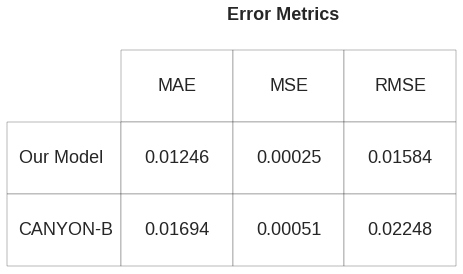

In [ ]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(2,3))

# get metrics for DNN
mae = mean_absolute_error(outputs, test_predictions)
mse = mean_squared_error(outputs, test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# get metrics for CANYON-B
c_mae = mean_absolute_error(outputs, canyonb_outputs)
c_mse = mean_squared_error(outputs, canyonb_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][0] = np.round(c_mae, 5)
model_metrics[1][1] = np.round(c_mse, 5)
model_metrics[1][2] = np.round(c_rmse, 5)

# create table
# labels for columns and rows
col_labels = np.array(('MAE', 'MSE', 'RMSE'))
row_labels = np.array((final_model_name, 'CANYON-B'))
# add data to table
fig, ax = plt.subplots(1, figsize=(6,4))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics', y=1,
             ha='center', va='center', fontsize=18, weight='bold')
# scale plot
table.set_fontsize(18)
table.scale(1,6)
ax.axis('off')

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_metrics_table.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Shallow Test Dataset

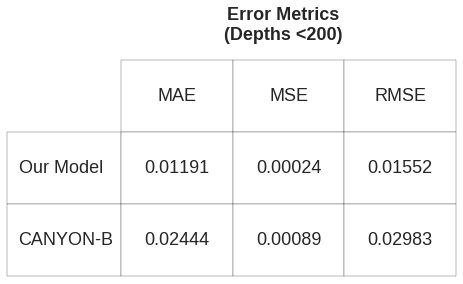

In [ ]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(2,3))

# get metrics for DNN
mae = mean_absolute_error(shallow_outputs, shallow_test_predictions)
mse = mean_squared_error(shallow_outputs, shallow_test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# get metrics for CANYON-B
c_mae = mean_absolute_error(shallow_outputs, shallow_canyonb_outputs)
c_mse = mean_squared_error(shallow_outputs, shallow_canyonb_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][0] = np.round(c_mae, 5)
model_metrics[1][1] = np.round(c_mse, 5)
model_metrics[1][2] = np.round(c_rmse, 5)

# create table
# labels for columns and rows
col_labels = np.array(('MAE', 'MSE', 'RMSE'))
row_labels = np.array((final_model_name, 'CANYON-B'))
# add data to table
fig, ax = plt.subplots(1, figsize=(6,4))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics' + d_label, y=1,
             ha='center', va='center', fontsize=18, weight='bold')
# scale plot
table.set_fontsize(18)
table.scale(1,6)
ax.axis('off')

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_metrics_table_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


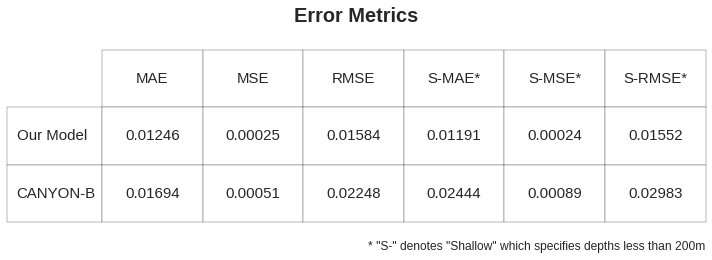

In [ ]:
# TEST INITIAL PERFORMANCE ON TRAINING, VALIDATION, & TESTING SETS

model_metrics = np.zeros((2,6))

# get metrics for DNN
e_mae = mean_absolute_error(outputs, test_predictions)
e_mse = mean_squared_error(outputs, test_predictions)
e_rmse = math.sqrt(e_mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(e_mae, 5)
model_metrics[0][1] = np.round(e_mse, 5)
model_metrics[0][2] = np.round(e_rmse, 5)
# get metrics for DNN
e_mae = mean_absolute_error(shallow_outputs, shallow_test_predictions)
e_mse = mean_squared_error(shallow_outputs, shallow_test_predictions)
e_rmse = math.sqrt(e_mse)
# round metrics to 5 decimal places
model_metrics[0][3] = np.round(e_mae, 5)
model_metrics[0][4] = np.round(e_mse, 5)
model_metrics[0][5] = np.round(e_rmse, 5)

# get metrics for CANYON-B
c_mae = mean_absolute_error(outputs, canyonb_outputs)
c_mse = mean_squared_error(outputs, canyonb_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][0] = np.round(c_mae, 5)
model_metrics[1][1] = np.round(c_mse, 5)
model_metrics[1][2] = np.round(c_rmse, 5)
# get metrics for CANYON-B
c_mae = mean_absolute_error(shallow_outputs, shallow_canyonb_outputs)
c_mse = mean_squared_error(shallow_outputs, shallow_canyonb_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][3] = np.round(c_mae, 5)
model_metrics[1][4] = np.round(c_mse, 5)
model_metrics[1][5] = np.round(c_rmse, 5)

# create table
# labels for columns and rows
col_labels = ['MAE', 'MSE', 'RMSE', 'S-MAE*', 'S-MSE*', 'S-RMSE*']
row_labels = [final_model_name, 'CANYON-B']

# add data to table
fig, ax = plt.subplots(1, figsize=(10,3.5))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
                 rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics',
             ha='center', va='center', fontsize=20, weight='bold')
# scale plot
table.set_fontsize(15)
table.scale(1,4)
ax.axis('off')

plt.text(1,0, "* \"S-\" denotes \"Shallow\" which specifies depths less than 200m",
         ha='right', fontsize=12)

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'combined_err_metrics.png', bbox_inches='tight')
if show_figs:
  plt.show()

# Error vs Inputs

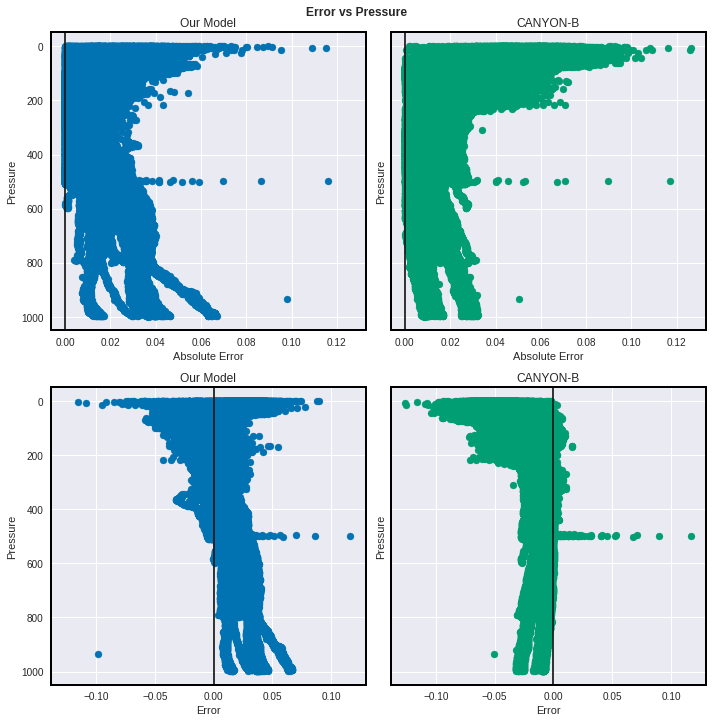

In [ ]:
# get errors (estimations - observations)
error = test_predictions - outputs
error2 = canyonb_outputs - outputs

fig, axs = plt.subplots(2,2, sharex='row', sharey=True, figsize=(10,10))

abs_error = abs(error)
abs_error2 = abs(error2)

axs[0,0].scatter(abs_error, inputs[:,3], 
                 color=m_col)
axs[0,1].scatter(abs_error2, inputs[:,3], 
                 color=c_col)

axs[1,0].scatter(error, inputs[:,3], 
                 color=m_col)
axs[1,1].scatter(error2, inputs[:,3], 
                 color=c_col)

axs[0,0].axvline(x=0, color='k')
axs[0,1].axvline(x=0, color='k')
axs[1,0].axvline(x=0, color='k')
axs[1,1].axvline(x=0, color='k')

axs[0,0].invert_yaxis()

fig.suptitle('Error vs Pressure', y=1,
             weight='bold')

axs[0,0].set_title(final_model_name)
axs[0,0].set_ylabel('Pressure')
axs[0,0].set_xlabel('Absolute Error')

axs[1,0].set_title(final_model_name)
axs[1,0].set_ylabel('Pressure')
axs[1,0].set_xlabel('Error')

axs[0,1].set_title('CANYON-B')
axs[0,1].set_ylabel('Pressure')
axs[0,1].set_xlabel('Absolute Error')

axs[1,1].set_title('CANYON-B')
axs[1,1].set_ylabel('Pressure')
axs[1,1].set_xlabel('Error')

plt.tight_layout()
plt.show()

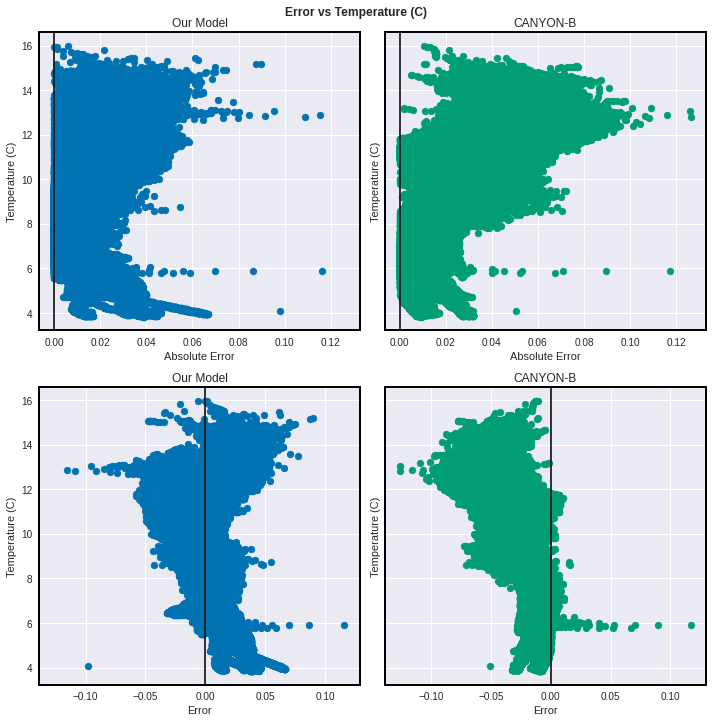

In [ ]:
# get errors (estimations - observations)
error = test_predictions - outputs
error2 = canyonb_outputs - outputs

fig, axs = plt.subplots(2,2, sharex='row', sharey=True, figsize=(10,10))

abs_error = abs(error)
abs_error2 = abs(error2)

axs[0,0].scatter(abs_error, inputs[:,4], 
                 color=m_col)
axs[0,1].scatter(abs_error2, inputs[:,4], 
                 color=c_col)

axs[1,0].scatter(error, inputs[:,4], 
                 color=m_col)
axs[1,1].scatter(error2, inputs[:,4], 
                 color=c_col)

axs[0,0].axvline(x=0, color='k')
axs[0,1].axvline(x=0, color='k')
axs[1,0].axvline(x=0, color='k')
axs[1,1].axvline(x=0, color='k')

fig.suptitle('Error vs Temperature (C)', y=1,
             weight='bold')

axs[0,0].set_title(final_model_name)
axs[0,0].set_ylabel('Temperature (C)')
axs[0,0].set_xlabel('Absolute Error')

axs[1,0].set_title(final_model_name)
axs[1,0].set_ylabel('Temperature (C)')
axs[1,0].set_xlabel('Error')

axs[0,1].set_title('CANYON-B')
axs[0,1].set_ylabel('Temperature (C)')
axs[0,1].set_xlabel('Absolute Error')

axs[1,1].set_title('CANYON-B')
axs[1,1].set_ylabel('Temperature (C)')
axs[1,1].set_xlabel('Error')

plt.tight_layout()
plt.show()

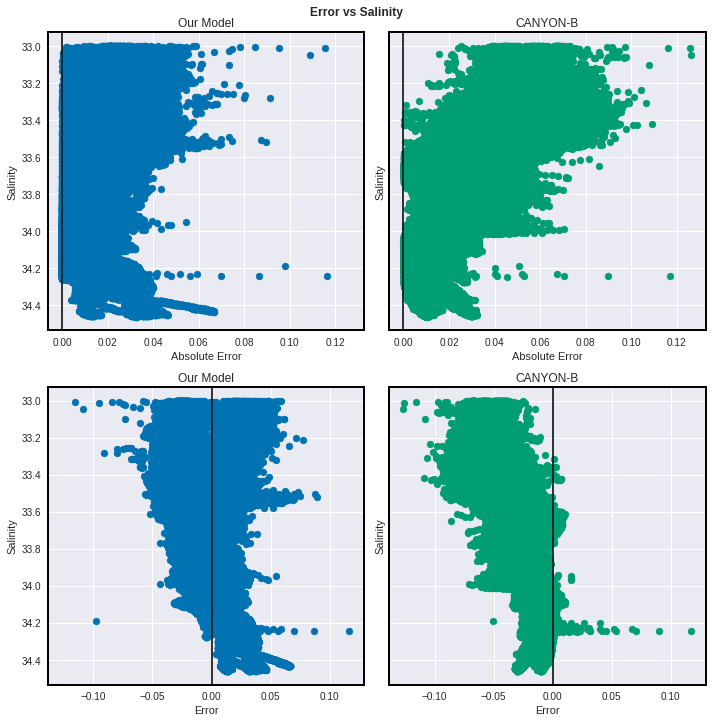

In [ ]:
# get errors (estimations - observations)
error = test_predictions - outputs
error2 = canyonb_outputs - outputs

fig, axs = plt.subplots(2,2, sharex='row', sharey=True, figsize=(10,10))

abs_error = abs(error)
abs_error2 = abs(error2)

axs[0,0].scatter(abs_error, inputs[:,5], 
                 color=m_col)
axs[0,1].scatter(abs_error2, inputs[:,5], 
                 color=c_col)

axs[1,0].scatter(error, inputs[:,5], 
                 color=m_col)
axs[1,1].scatter(error2, inputs[:,5], 
                 color=c_col)

axs[0,0].axvline(x=0, color='k')
axs[0,1].axvline(x=0, color='k')
axs[1,0].axvline(x=0, color='k')
axs[1,1].axvline(x=0, color='k')

axs[0,0].invert_yaxis()

fig.suptitle('Error vs Salinity', y=1,
             weight='bold')

axs[0,0].set_title(final_model_name)
axs[0,0].set_ylabel('Salinity')
axs[0,0].set_xlabel('Absolute Error')

axs[1,0].set_title(final_model_name)
axs[1,0].set_ylabel('Salinity')
axs[1,0].set_xlabel('Error')

axs[0,1].set_title('CANYON-B')
axs[0,1].set_ylabel('Salinity')
axs[0,1].set_xlabel('Absolute Error')

axs[1,1].set_title('CANYON-B')
axs[1,1].set_ylabel('Salinity')
axs[1,1].set_xlabel('Error')

plt.tight_layout()
plt.show()

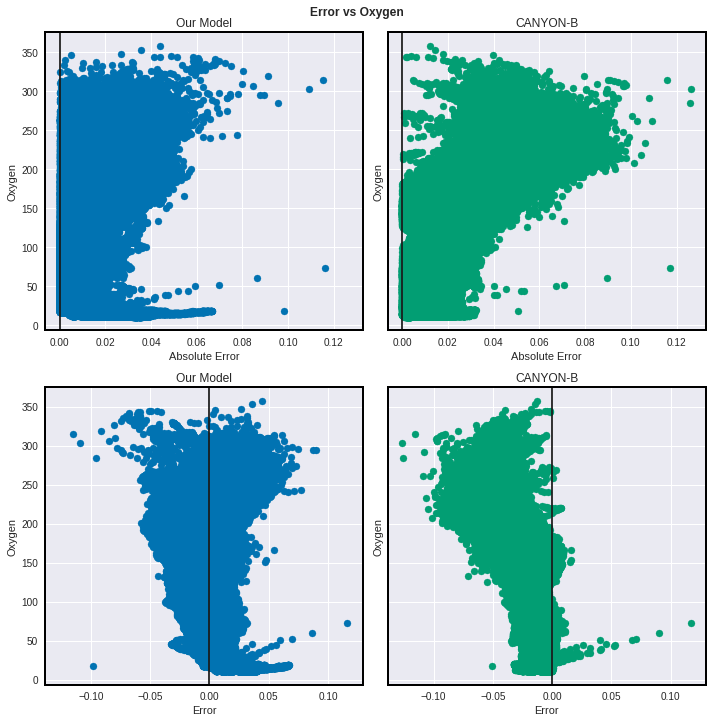

In [ ]:
# get errors (estimations - observations)
error = test_predictions - outputs
error2 = canyonb_outputs - outputs

fig, axs = plt.subplots(2,2, sharex='row', sharey=True, figsize=(10,10))

abs_error = abs(error)
abs_error2 = abs(error2)

axs[0,0].scatter(abs_error, inputs[:,6], 
                 color=m_col)
axs[0,1].scatter(abs_error2, inputs[:,6], 
                 color=c_col)

axs[1,0].scatter(error, inputs[:,6], 
                 color=m_col)
axs[1,1].scatter(error2, inputs[:,6], 
                 color=c_col)

axs[0,0].axvline(x=0, color='k')
axs[0,1].axvline(x=0, color='k')
axs[1,0].axvline(x=0, color='k')
axs[1,1].axvline(x=0, color='k')

fig.suptitle('Error vs Oxygen', y=1,
             weight='bold')

axs[0,0].set_title(final_model_name)
axs[0,0].set_ylabel('Oxygen')
axs[0,0].set_xlabel('Absolute Error')

axs[1,0].set_title(final_model_name)
axs[1,0].set_ylabel('Oxygen')
axs[1,0].set_xlabel('Error')

axs[0,1].set_title('CANYON-B')
axs[0,1].set_ylabel('Oxygen')
axs[0,1].set_xlabel('Absolute Error')

axs[1,1].set_title('CANYON-B')
axs[1,1].set_ylabel('Oxygen')
axs[1,1].set_xlabel('Error')

plt.tight_layout()
plt.show()